# Video Game Sales Analysis for Ice

Ice, an international online video game store, aims to enhance its understanding of the factors driving video game success across different platforms, genres, and regions. By analyzing data on game sales, user and critic reviews, platform popularity, and genre performance, Ice seeks to develop strategic insights to inform future game releases and marketing campaigns.

In this project, we explore data on game sales spanning multiple years and regions, focusing on key questions:

* Platform and Genre Trends: Which platforms and genres are most profitable, and how do they vary by region?

* Impact of Reviews on Sales: How do critic and user reviews influence a game’s commercial success?

* Regional Preferences: What are the unique platform, genre, and rating preferences in North America, Europe, and Japan?

* User Ratings Across Platforms and Genres: Are there significant differences in user satisfaction across platforms and genres?

By examining these questions, this analysis provides Ice with actionable insights for targeting future releases, optimizing marketing strategies, and aligning content with the preferences of its global audience. The results of this analysis will help Ice identify potential market winners and strategically plan campaigns that cater to diverse regional and platform choices.

**Note: All sales figures in this dataset are represented in millions of USD.**

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [99]:
# Load dataset
games_df = pd.read_csv('games.csv')

In [101]:
# Display general information
print(games_df.info())
print(games_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None
                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29

In [103]:
# Data Preparation
games_df.columns = games_df.columns.str.lower()
games_df['year_of_release'] = games_df['year_of_release'].fillna(0).astype(int)
games_df['user_score'] = pd.to_numeric(games_df['user_score'], errors='coerce')
games_df['total_sales'] = games_df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

# Here, I'm leaving most missing values as NaN for now; let’s document this decision as we analyze further
# - 'Critic_Score', 'User_Score', and 'Rating' contain many missing entries that may reflect unavailable data

In [105]:
# Display prepared data sample to verify changes
print(games_df.info())
print(games_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
 11  total_sales      16715 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB
None
                       name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii             2006        Sports     41.36   
1         Super Ma

# Exploratory Data Analysis

## Game Releases by Year

The analysis of game releases over the years reveals key trends in the gaming industry:

**Growth and Peaks:** The data shows periods of growth where game releases increased significantly, often aligning with technological advancements, such as new console generations or the rise of digital distribution.

**Declines:** Years with fewer releases may reflect market saturation, economic factors, or shifts in consumer preferences.

**Recent Trends:** Understanding release patterns helps identify periods of high competition and potential opportunities for timing new releases when the market is less saturated.

Overall, these insights provide historical context, helping predict future release trends and optimal timing for launching new games to capture consumer attention.

In [108]:
# Filter out any invalid years (e.g., 0 or other placeholder values)
games_by_year = games_df[games_df['year_of_release'] > 1900]['year_of_release'].value_counts().sort_index()

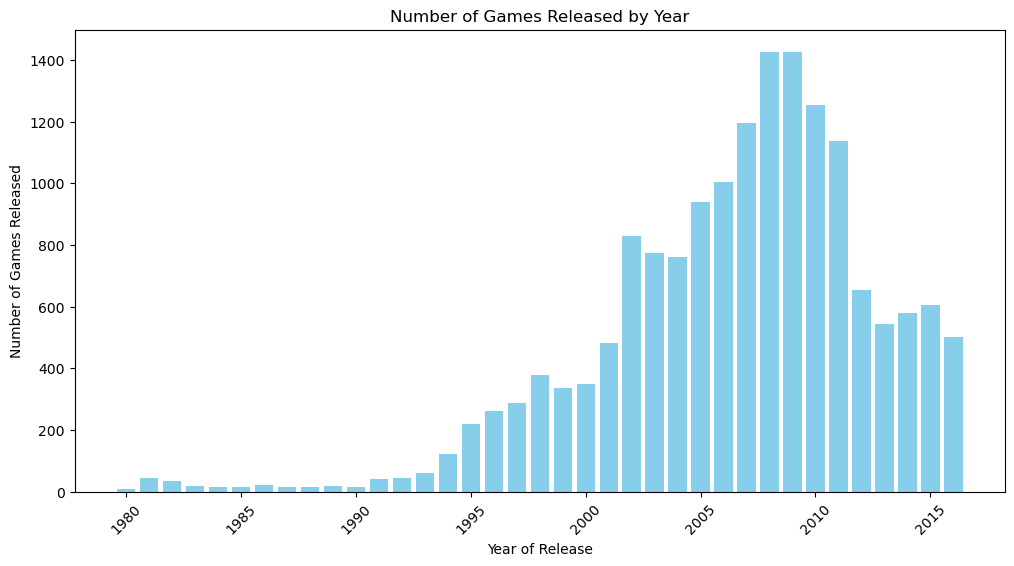

In [110]:
# Plot the number of game releases per year
plt.figure(figsize=(12, 6))
plt.bar(games_by_year.index, games_by_year.values, color='skyblue')
plt.xlabel("Year of Release")
plt.ylabel("Number of Games Released")
plt.title("Number of Games Released by Year")
plt.xticks(rotation=45)
plt.show()

## Top Platforms by Sales and Yearly Distribution

Analyzing the yearly sales distribution of top platforms provides insights into each platform's market performance over time:

**Peak Sales Periods:** Each platform’s sales trends reveal peak periods that often align with the early years following a platform's release, suggesting high engagement during its initial lifecycle.

**Platform Longevity:** Some platforms demonstrate extended periods of strong sales, indicating a lasting appeal and a loyal user base, while others experience faster declines as newer platforms emerge.

**Market Shifts:** Platforms with consistent sales over multiple years illustrate stability, while those with steep declines highlight shifts in consumer preference or competition from new technologies.

These insights help identify stable platforms for long-term investment and highlight those nearing the end of their lifecycle, assisting in strategic planning for new game releases.

In [113]:
# Calculate total sales by platform and identify top platforms
platform_sales = games_df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
top_platforms = platform_sales.head(5).index  # Select the top 5 platforms for analysis

In [115]:
# Filter data for only the top platforms and valid years
top_platform_data = games_df[(games_df['platform'].isin(top_platforms)) & (games_df['year_of_release'] >= 1980)]

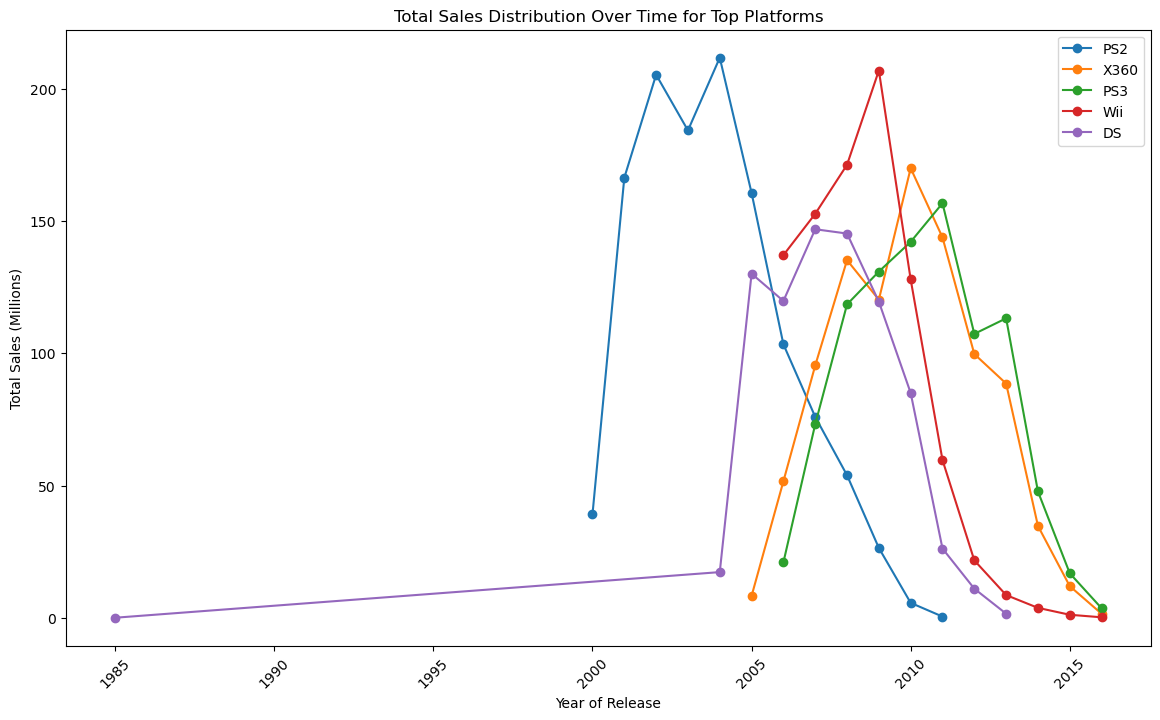

In [117]:
# Plot sales distribution for each top platform by year
plt.figure(figsize=(14, 8))
for platform in top_platforms:
    platform_data = top_platform_data[top_platform_data['platform'] == platform]
    sales_by_year = platform_data.groupby('year_of_release')['total_sales'].sum()
    plt.plot(sales_by_year.index, sales_by_year.values, marker='o', label=platform)

# Labeling the plot
plt.xlabel("Year of Release")
plt.ylabel("Total Sales (Millions)")
plt.title("Total Sales Distribution Over Time for Top Platforms")
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Platform Lifespans

The analysis of platform lifespans provides valuable insights into how long each platform remains relevant and competitive in the gaming market:

**Longevity and Stability:** Platforms with longer lifespans demonstrate a strong market presence and ongoing consumer interest, making them attractive for long-term game development and investment.

**Rapid Turnover:** Platforms with shorter lifespans often face rapid declines, likely due to technological advancements or competition from newer platforms, signaling a higher risk for long-term projects.

**Lifecycle Patterns:** Understanding platform longevity helps in timing releases, as platforms with extended lifespans may support multiple game releases over their lifecycle, maximizing potential sales.

These insights aid in strategic decision-making, helping identify stable platforms for future releases and recognizing those at risk of obsolescence.

In [120]:
# Identify first and last year of sales for each platform
platform_years = games_df.groupby('platform')['year_of_release'].agg(['min', 'max'])
platform_years['lifespan'] = platform_years['max'] - platform_years['min']

In [122]:
# Display platform lifespans to understand how long they tend to stay relevant
print(platform_years.sort_values(by='lifespan', ascending=False))

           min   max  lifespan
platform                      
3DS          0  2016      2016
X360         0  2016      2016
Wii          0  2016      2016
PSV          0  2016      2016
PC           0  2016      2016
PS3          0  2016      2016
PSP          0  2015      2015
DS           0  2013      2013
PS2          0  2011      2011
XB           0  2008      2008
GBA          0  2007      2007
GC           0  2007      2007
PS           0  2003      2003
N64          0  2002      2002
GB           0  2001      2001
2600         0  1989      1989
NES       1983  1994        11
DC        1998  2008        10
SNES      1990  1999         9
SAT       1994  1999         5
WiiU      2012  2016         4
GEN       1990  1994         4
PS4       2013  2016         3
NG        1993  1996         3
XOne      2013  2016         3
WS        1999  2001         2
3DO       1994  1995         1
SCD       1993  1994         1
PCFX      1996  1996         0
TG16      1995  1995         0
GG      

## Top Platforms by Sales (2010 and onward)

**Market Leaders:** Certain platforms consistently lead in sales, underscoring their broad appeal and market dominance. These platforms provide promising opportunities for future releases due to their established user base and ongoing popularity.

**Emerging Trends:** The data may reveal newer platforms gaining traction, suggesting potential growth and investment opportunities in these platforms.

**Diminished Platforms:** Platforms with declining sales may indicate shifts in consumer preferences, technological advancements, or competition, suggesting a potential phase-out of these platforms.

Overall, this analysis aids in identifying the most viable platforms for future game releases, enabling strategic focus on those likely to yield the highest returns in the near term.

In [125]:
# Filter Data for Relevant Period (2010 and onward)
filtered_games_df = games_df[games_df['year_of_release'] >= 2010]

In [127]:
# Verify the filtering worked by checking the minimum year
print(filtered_games_df['year_of_release'].min())  # Should be 2010 or later
print(filtered_games_df.head())

2010
                              name platform  year_of_release         genre  \
14              Kinect Adventures!     X360             2010          Misc   
16              Grand Theft Auto V      PS3             2013        Action   
23              Grand Theft Auto V     X360             2013        Action   
27     Pokemon Black/Pokemon White       DS             2010  Role-Playing   
29  Call of Duty: Modern Warfare 3     X360             2011       Shooter   

    na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
14     15.00      4.89      0.24         1.69          61.0         6.3   
16      7.02      9.09      0.98         3.96          97.0         8.2   
23      9.66      5.14      0.06         1.41          97.0         8.1   
27      5.51      3.17      5.65         0.80           NaN         NaN   
29      9.04      4.24      0.13         1.32          88.0         3.4   

   rating  total_sales  
14      E        21.82  
16      M        21.05  


In [129]:
# Calculate total sales by platform in the filtered data
top_platform_sales = filtered_games_df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
leading_platforms = top_platform_sales.head(5).index  # Select top 5 platforms

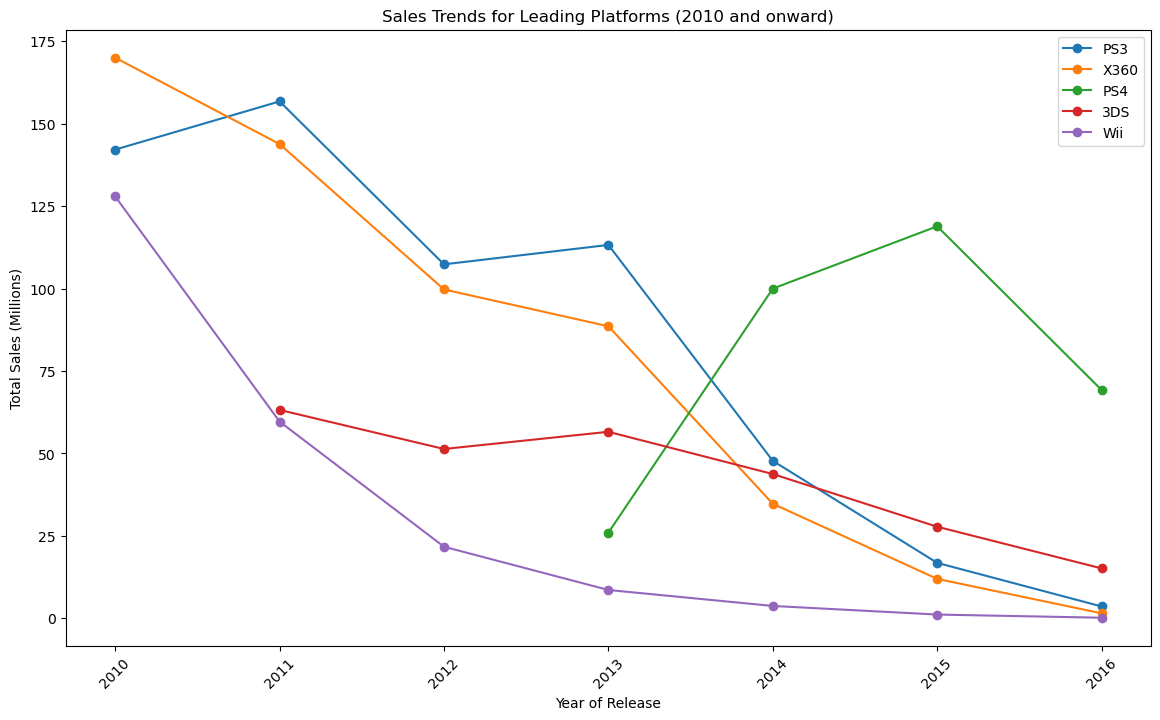

In [131]:
# Plot yearly sales trends for the top platforms
plt.figure(figsize=(14, 8))
for platform in leading_platforms:
    platform_data = filtered_games_df[filtered_games_df['platform'] == platform]
    sales_by_year = platform_data.groupby('year_of_release')['total_sales'].sum()
    plt.plot(sales_by_year.index, sales_by_year.values, marker='o', label=platform)

# Labeling the plot
plt.xlabel("Year of Release")
plt.ylabel("Total Sales (Millions)")
plt.title("Sales Trends for Leading Platforms (2010 and onward)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Sales Distribution by Platform

The analysis of sales distribution by platform provides insights into the variability and overall success of game sales across different platforms:

**High-Performing Platforms:** Platforms with consistently high median sales suggest stable, profitable opportunities for game releases. These platforms may attract a broad audience and have established ecosystems that drive game purchases.

**Wide Variability in Sales:** Platforms with a wide range of sales (indicated by large interquartile ranges or frequent outliers) show that while some games perform exceptionally well, others may struggle. This variability highlights the competitive nature of these platforms.

**Outliers:** Outliers with exceptionally high sales represent blockbuster games that drive significant revenue. These outliers emphasize the potential for major successes on popular platforms, even if average sales remain moderate.

This analysis helps identify platforms that offer stable returns and those where high sales are achievable but may require targeted marketing or strong brand presence to reach blockbuster status.

In [134]:
# Filter out platforms with very few games to avoid skewed box plots
platform_game_counts = filtered_games_df['platform'].value_counts()
popular_platforms = platform_game_counts[platform_game_counts > 20].index
filtered_popular_platforms = filtered_games_df[filtered_games_df['platform'].isin(popular_platforms)]

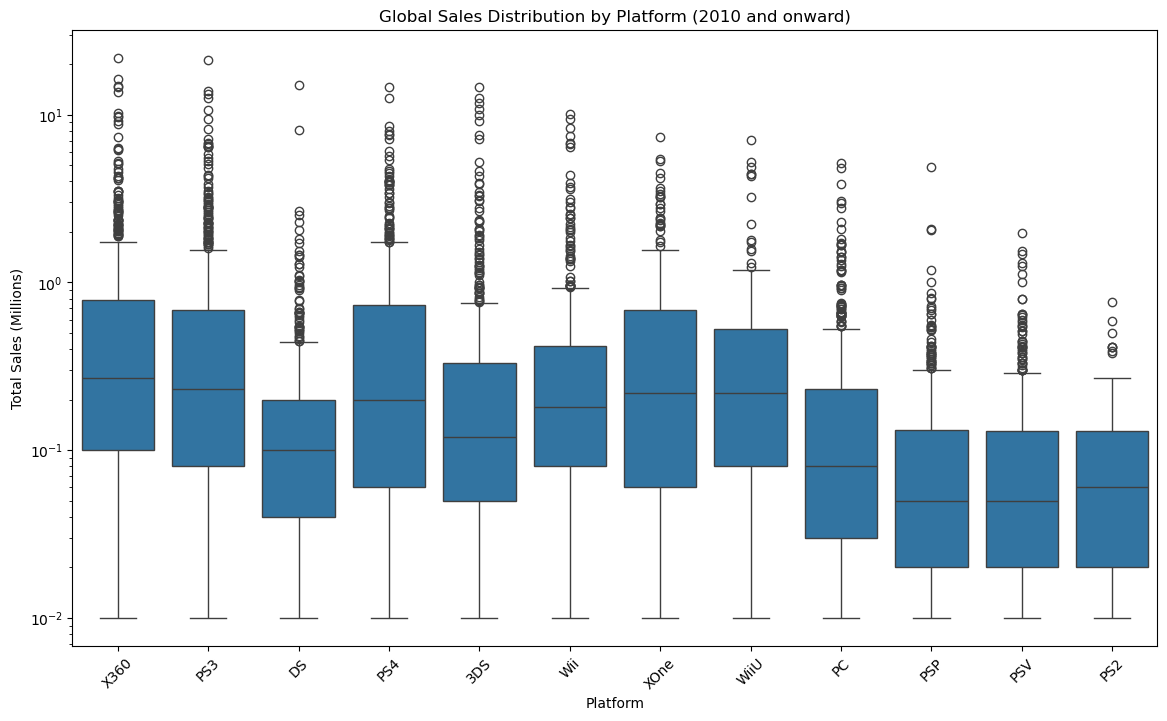

In [136]:
# Plot the box plot for global sales by platform
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_popular_platforms, x='platform', y='total_sales')
plt.yscale('log')  # Use a log scale to handle wide range of sales values
plt.xlabel("Platform")
plt.ylabel("Total Sales (Millions)")
plt.title("Global Sales Distribution by Platform (2010 and onward)")
plt.xticks(rotation=45)
plt.show()

## Impact of Reviews on Sales (PS4)

Analyzing the relationship between reviews and sales for the PS4 platform provides insights into how critic and user ratings affect game performance:

**Critic Reviews:** A positive correlation between critic scores and sales indicates that higher-rated games tend to sell better on the PS4. This suggests that professional reviews play a significant role in influencing consumer purchasing decisions, possibly due to increased visibility and credibility.

**User Reviews:** A similar trend with user scores shows that players’ opinions also impact sales, though the strength of this correlation may vary. High user ratings can boost sales through word-of-mouth and community endorsements, further enhancing a game’s success.

**Marketing and Review Strategy:** The positive impact of reviews on sales highlights the importance of quality and early review strategies. Ensuring positive reviews from both critics and users can be instrumental in maximizing sales.

This analysis underscores the value of good reviews for PS4 games, suggesting that games with strong ratings are more likely to succeed in the market.

In [139]:
# Impact of Reviews on Sales for One Platform (e.g., PS4):
# Choose a popular platform, e.g., PS4
selected_platform = 'PS4'
platform_data = filtered_games_df[filtered_games_df['platform'] == selected_platform]

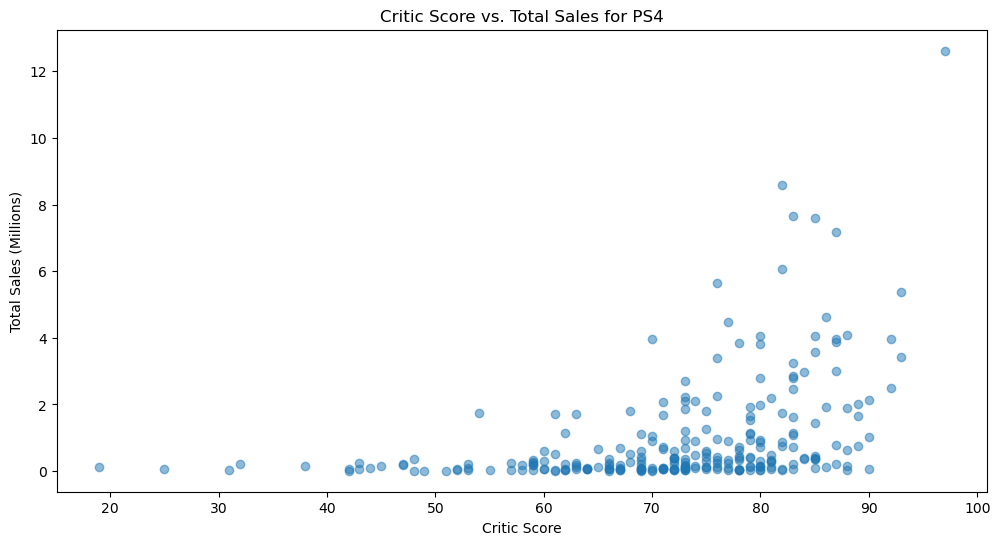

In [141]:
# Scatter plot for Critic Score vs. Total Sales
plt.figure(figsize=(12, 6))
plt.scatter(platform_data['critic_score'], platform_data['total_sales'], alpha=0.5)
plt.xlabel("Critic Score")
plt.ylabel("Total Sales (Millions)")
plt.title(f"Critic Score vs. Total Sales for {selected_platform}")
plt.show()

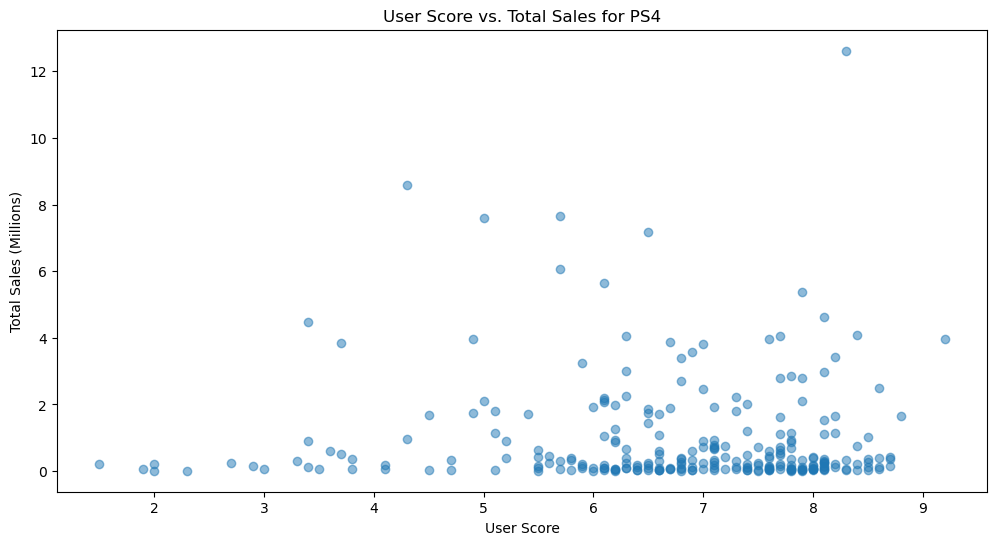

In [143]:
# Scatter plot for User Score vs. Total Sales
plt.figure(figsize=(12, 6))
plt.scatter(platform_data['user_score'], platform_data['total_sales'], alpha=0.5)
plt.xlabel("User Score")
plt.ylabel("Total Sales (Millions)")
plt.title(f"User Score vs. Total Sales for {selected_platform}")
plt.show()

## Correlation between Critic Score and Total Sales for PS4: 0.41

**Interpretation:** A positive correlation of 0.41 suggests a moderate positive relationship between critic scores and total sales on the PS4. This means that, generally, higher critic ratings are associated with higher sales, although the correlation is not strong enough to predict sales based solely on critic scores.

**Implication:** Critic scores seem to have some influence on consumer purchasing behavior. Games with favorable critic reviews may receive more attention, potentially boosting their sales through increased credibility and visibility. However, other factors (such as marketing, genre, and game brand) are likely also significant in driving total sales.

## Correlation between User Score and Total Sales for PS4: -0.03

**Interpretation:** A near-zero, slightly negative correlation of -0.03 suggests that there is virtually no linear relationship between user scores and total sales on the PS4. In other words, higher or lower user ratings do not appear to have a consistent effect on sales.

**Implication:** Unlike critic scores, user ratings seem to have minimal impact on total sales for PS4 games in this dataset.

### Summary
Overall, critic scores appear to moderately influence sales, suggesting that favorable critical reception can positively impact game success on the PS4. User scores, however, do not show a significant impact, indicating that players may make purchase decisions based on factors other than user reviews.

In [146]:
# Calculate correlations
critic_corr = platform_data['critic_score'].corr(platform_data['total_sales'])
user_corr = platform_data['user_score'].corr(platform_data['total_sales'])

print(f"Correlation between Critic Score and Total Sales for {selected_platform}: {critic_corr}")
print(f"Correlation between User Score and Total Sales for {selected_platform}: {user_corr}")

Correlation between Critic Score and Total Sales for PS4: 0.40656790206178095
Correlation between User Score and Total Sales for PS4: -0.031957110204556424


## Multi-Platform Games Sales Comparison

The analysis of multi-platform game sales highlights the performance of top-selling games released across multiple platforms, providing insights into cross-platform appeal and sales distribution:

**Cross-Platform Appeal:** Games with strong sales across multiple platforms indicate broad appeal, capturing diverse user bases across different consoles and systems. These games tend to perform well regardless of platform, underscoring the benefits of multi-platform releases for maximizing reach and revenue.

**Sales Variability by Platform:** Some games show higher sales on specific platforms, suggesting certain consoles may align better with particular game types or genres. Understanding these platform preferences can inform marketing and development focus for future releases.

**Revenue Maximization:** Multi-platform releases allow publishers to reach more players, reducing dependency on a single platform’s user base. This strategy can help mitigate risk and increase total sales by catering to audiences across various consoles and systems.

Overall, this analysis demonstrates the advantage of multi-platform releases for top games, highlighting the potential to optimize revenue through cross-platform availability and tailored marketing strategies based on platform-specific performance.

In [149]:
# Compare Sales of Top-Selling Games Across Platforms

# Filter for games available on multiple platforms with non-zero sales
multi_platform_games = filtered_games_df.groupby('name').filter(
    lambda x: len(x['platform'].unique()) > 1 and x['total_sales'].sum() > 0
)

In [151]:
# Group by game title and calculate total sales across all platforms
top_multi_platform_games = multi_platform_games.groupby('name')['total_sales'].sum()

In [153]:
# Select top 10 best-selling multi-platform games
top_games = top_multi_platform_games.nlargest(10).index
top_games_data = multi_platform_games[multi_platform_games['name'].isin(top_games)]

In [155]:
# Group by game title and platform, then sum total sales
game_platform_sales = top_games_data.groupby(['name', 'platform'])['total_sales'].sum().unstack()

In [157]:
# Display the sales comparison table (first 10 rows for overview)
print(game_platform_sales)

platform                         3DS    DS    PC    PS3    PS4   PSV   Wii  \
name                                                                         
Call of Duty: Advanced Warfare   NaN   NaN  0.41   4.36   7.66   NaN   NaN   
Call of Duty: Black Ops          NaN  0.58   NaN  12.63    NaN   NaN  1.37   
Call of Duty: Black Ops 3        NaN   NaN  0.26   1.69  14.63   NaN   NaN   
Call of Duty: Black Ops II       NaN   NaN  1.52  13.79    NaN   NaN   NaN   
Call of Duty: Ghosts             NaN   NaN  0.69   9.36   3.83   NaN   NaN   
Call of Duty: Modern Warfare 3   NaN   NaN  1.71  13.33    NaN   NaN  0.83   
FIFA 15                         0.46   NaN  0.29   4.28   6.08  0.60  0.56   
Grand Theft Auto V               NaN   NaN  1.17  21.05  12.62   NaN   NaN   
Minecraft                        NaN   NaN   NaN   5.27   4.32  1.96   NaN   
The Elder Scrolls V: Skyrim      NaN   NaN  3.88   6.40   1.32   NaN   NaN   

platform                        WiiU   X360  XOne  
name       

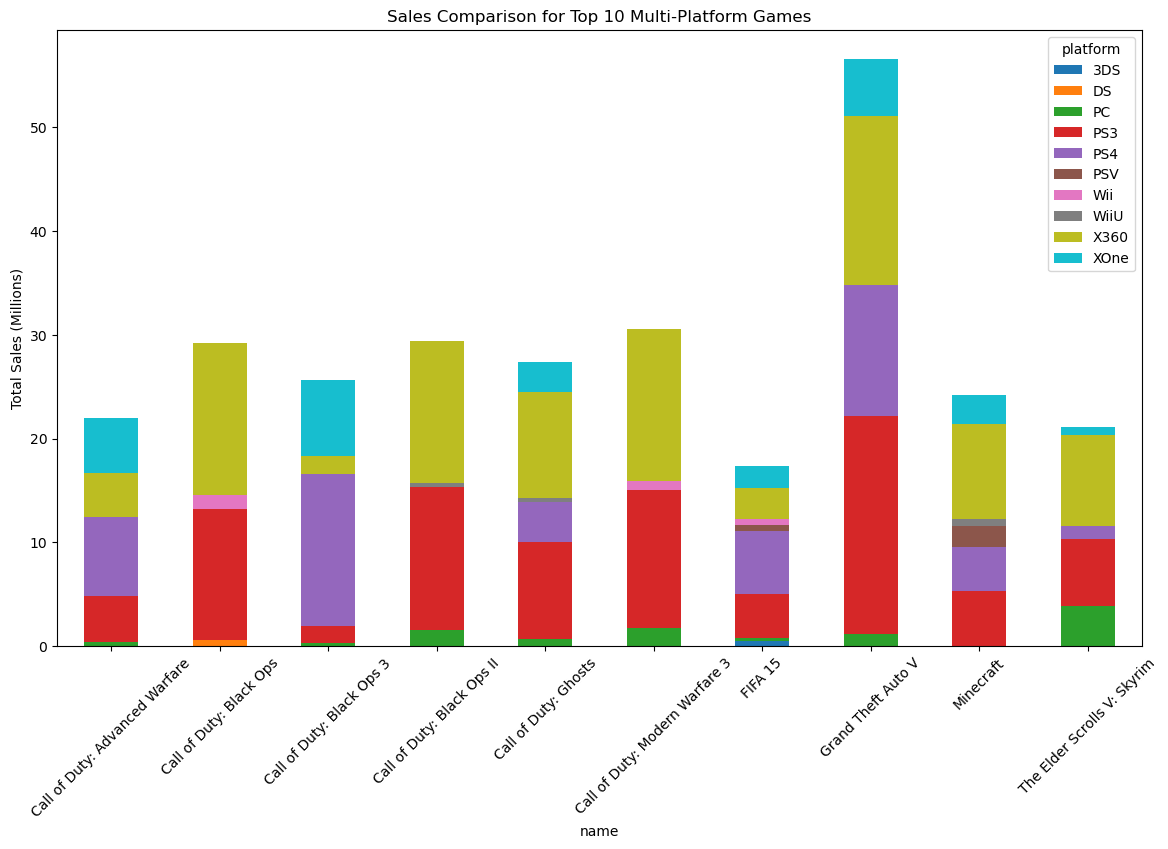

In [159]:
# Plot sales comparison for the top games
game_platform_sales.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.ylabel("Total Sales (Millions)")
plt.title("Sales Comparison for Top 10 Multi-Platform Games")
plt.xticks(rotation=45)
plt.show()

## Genre Profitability Analysis

The genre profitability analysis sheds light on the performance of different game genres in terms of total and average sales:

**High-Performing Genres:** Certain genres consistently achieve high total sales, indicating strong market demand and broad appeal. These genres represent significant revenue opportunities and are likely to attract a large player base, making them viable targets for future releases.

**Niche but Profitable Genres:** Some genres may not achieve the highest total sales but have high average sales per game. This suggests that, while fewer games are released within these genres, they perform well individually, potentially indicating dedicated, loyal audiences.

**Low-Performing Genres:** Genres with both low total and average sales may have limited appeal or face intense competition. These genres may be less profitable overall, and investment in these areas could carry higher risk unless there’s potential for differentiation.

This analysis helps prioritize investment by identifying genres with the greatest revenue potential and highlighting those that may benefit from targeted marketing or unique positioning to improve profitability.

In [162]:
# Profitability Analysis by Genre

# Count of Games by Genre
genre_counts = filtered_games_df['genre'].value_counts()
print("Number of Games by Genre:\n", genre_counts)

Number of Games by Genre:
 genre
Action          1495
Misc             576
Sports           575
Role-Playing     568
Adventure        563
Shooter          410
Racing           237
Simulation       217
Fighting         199
Strategy         170
Platform         153
Puzzle           114
Name: count, dtype: int64


In [164]:
# Total Sales by Genre
genre_sales = filtered_games_df.groupby('genre')['total_sales'].sum().sort_values(ascending=False)
print("\nTotal Sales by Genre:\n", genre_sales)


Total Sales by Genre:
 genre
Action          673.09
Shooter         479.74
Sports          328.39
Role-Playing    315.28
Misc            234.56
Racing          122.68
Platform        119.72
Fighting         81.59
Simulation       71.75
Adventure        61.00
Strategy         35.84
Puzzle           20.60
Name: total_sales, dtype: float64


In [166]:
# Average Sales per Game by Genre
average_genre_sales = genre_sales / genre_counts
average_genre_sales = average_genre_sales.sort_values(ascending=False)
print("\nAverage Sales per Game by Genre:\n", average_genre_sales)


Average Sales per Game by Genre:
 genre
Shooter         1.170098
Platform        0.782484
Sports          0.571113
Role-Playing    0.555070
Racing          0.517637
Action          0.450227
Fighting        0.410000
Misc            0.407222
Simulation      0.330645
Strategy        0.210824
Puzzle          0.180702
Adventure       0.108348
dtype: float64


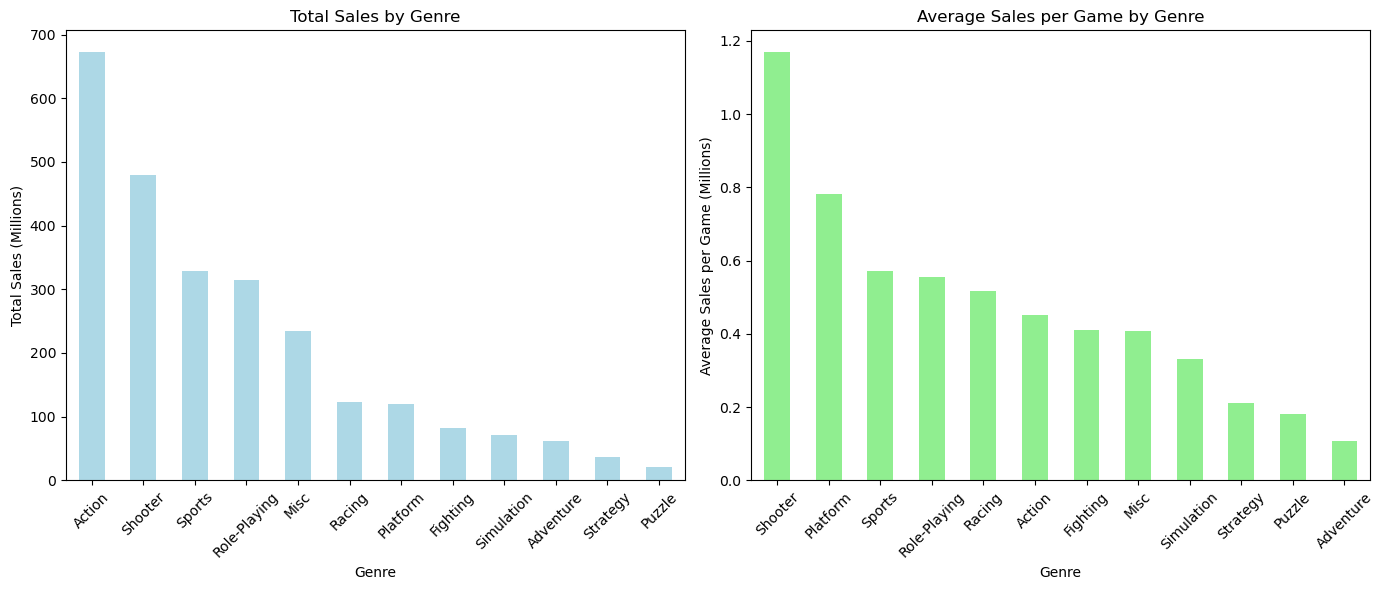

In [168]:
# Plot the distribution of total and average sales by genre
plt.figure(figsize=(14, 6))

# Plot total sales by genre
plt.subplot(1, 2, 1)
genre_sales.plot(kind='bar', color='lightblue')
plt.xlabel("Genre")
plt.ylabel("Total Sales (Millions)")
plt.title("Total Sales by Genre")
plt.xticks(rotation=45)

# Plot average sales by genre
plt.subplot(1, 2, 2)
average_genre_sales.plot(kind='bar', color='lightgreen')
plt.xlabel("Genre")
plt.ylabel("Average Sales per Game (Millions)")
plt.title("Average Sales per Game by Genre")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Regional Profiles for NA, EU, JP

The regional profile analysis provides valuable insights into the preferences of gamers across North America (NA), Europe (EU), and Japan (JP), revealing distinct differences in platform and genre popularity as well as the impact of ESRB ratings:

**Platform Preferences:** Each region shows varying preferences for gaming platforms, reflecting cultural and economic differences. North America and Europe tend to favor certain consoles, while Japan may prefer others, possibly due to local brand loyalty and market presence. Recognizing these regional platform preferences can guide region-specific marketing and platform focus.

**Genre Popularity:** Genres that are popular in one region may perform differently in another. For instance, a genre that is top-performing in Japan may not be as popular in North America or Europe. These insights help tailor genre offerings to align with regional tastes, maximizing engagement by catering to local preferences.

**ESRB Ratings and Sales:** ESRB ratings reveal age-related market trends within each region. For example, some regions may have higher sales for games rated for mature audiences, while others show stronger interest in family-friendly or general-audience games. Understanding these trends helps refine age-targeted marketing and content strategies.

This regional analysis is essential for tailoring marketing and distribution strategies, enabling targeted investments that resonate with the unique preferences and demographics of each regional market.

In [171]:
# Regional Profiles for NA, EU, JP

# Define regions and sales columns
regions = {'NA': 'na_sales', 'EU': 'eu_sales', 'JP': 'jp_sales'}

In [173]:
# Top Five Platforms by Region
for region, sales_column in regions.items():
    print(f"\nTop 5 Platforms in {region}:")
    top_platforms = filtered_games_df.groupby('platform')[sales_column].sum().sort_values(ascending=False).head(5)
    print(top_platforms)


Top 5 Platforms in NA:
platform
X360    334.18
PS3     229.25
Wii     121.20
PS4     108.74
XOne     93.12
Name: na_sales, dtype: float64

Top 5 Platforms in EU:
platform
PS3     213.60
X360    163.41
PS4     141.09
PC       68.82
Wii      65.91
Name: eu_sales, dtype: float64

Top 5 Platforms in JP:
platform
3DS    100.62
PS3     59.26
PSP     42.20
DS      27.90
PSV     21.84
Name: jp_sales, dtype: float64


In [175]:
# Top Five Genres by Region
for region, sales_column in regions.items():
    print(f"\nTop 5 Genres in {region}:")
    top_genres = filtered_games_df.groupby('genre')[sales_column].sum().sort_values(ascending=False).head(5)
    print(top_genres)


Top 5 Genres in NA:
genre
Action          290.64
Shooter         237.47
Sports          156.81
Misc            123.80
Role-Playing    112.05
Name: na_sales, dtype: float64

Top 5 Genres in EU:
genre
Action          233.63
Shooter         171.45
Sports          116.84
Role-Playing     75.48
Misc             66.09
Name: eu_sales, dtype: float64

Top 5 Genres in JP:
genre
Role-Playing    103.54
Action           72.20
Misc             24.29
Platform         15.81
Adventure        15.67
Name: jp_sales, dtype: float64


In [177]:
# ESRB Ratings and Sales Impact by Region
for region, sales_column in regions.items():
    print(f"\nESRB Rating Impact on Sales in {region}:")
    esrb_sales = filtered_games_df.groupby('rating')[sales_column].sum().sort_values(ascending=False)
    print(esrb_sales)


ESRB Rating Impact on Sales in NA:
rating
M       382.22
E       271.15
T       160.81
E10+    159.38
EC        1.13
RP        0.00
Name: na_sales, dtype: float64

ESRB Rating Impact on Sales in EU:
rating
M       292.04
E       197.34
T       113.08
E10+     99.28
RP        0.03
EC        0.00
Name: eu_sales, dtype: float64

ESRB Rating Impact on Sales in JP:
rating
E       47.87
T       42.11
M       30.45
E10+    13.22
EC       0.00
RP       0.00
Name: jp_sales, dtype: float64


## Hypothesis Testing

The hypothesis testing results offer insights into user ratings across different platforms and genres:

### Hypothesis 1: Average User Ratings for Xbox One vs. PC

**Result:** The t-statistic of 0.025 and a high p-value of 0.98 indicate no statistically significant difference between the average user ratings for Xbox One and PC games. This suggests that user ratings are similar across these platforms, implying that player satisfaction or expectations for games on Xbox One and PC are generally aligned. This finding supports the idea that game content may appeal similarly to users across these two platforms.

### Hypothesis 2: Average User Ratings for Action vs. Sports Genres

**Result:** The t-statistic of 8.25 and a very low p-value (1.45e-15) reveal a statistically significant difference between the user ratings for Action and Sports genres. This indicates that users rate these genres differently, with either higher or lower satisfaction depending on genre. This finding suggests genre-specific user expectations and satisfaction, which could be influenced by gameplay style, content, or target audience.

### Hypothesis Conclusion

These hypothesis test results provide actionable insights:

**Platform Strategy:** Since user ratings do not significantly differ between Xbox One and PC, developers may focus on cross-platform strategies for these platforms without needing to adjust for user satisfaction differences.

**Genre-Specific Development:** The significant difference in ratings between Action and Sports genres highlights the need for genre-specific approaches in game development and marketing to cater to unique audience expectations.

These insights guide strategic decisions in game design, platform choice, and marketing to better align with user preferences across platforms and genres.

In [180]:
# Filter data for user ratings on Xbox One and PC platforms
xbox_one_ratings = filtered_games_df[(filtered_games_df['platform'] == 'XOne') & 
                                     (filtered_games_df['user_score'].notna())]['user_score']
pc_ratings = filtered_games_df[(filtered_games_df['platform'] == 'PC') & 
                               (filtered_games_df['user_score'].notna())]['user_score']

In [182]:
# Hypothesis 1: Xbox One vs. PC User Ratings
t_stat, p_value = ttest_ind(xbox_one_ratings, pc_ratings, equal_var=False)
print(f"Hypothesis 1 - Xbox One vs. PC User Ratings:\n t-statistic: {t_stat}, p-value: {p_value}")

Hypothesis 1 - Xbox One vs. PC User Ratings:
 t-statistic: 0.024879518331077908, p-value: 0.9801634129117883


In [184]:
# Filter data for user ratings in Action and Sports genres
action_ratings = filtered_games_df[(filtered_games_df['genre'] == 'Action') & 
                                   (filtered_games_df['user_score'].notna())]['user_score']
sports_ratings = filtered_games_df[(filtered_games_df['genre'] == 'Sports') & 
                                   (filtered_games_df['user_score'].notna())]['user_score']

In [186]:
# Hypothesis 2: Action vs. Sports Genre Ratings
t_stat_genre, p_value_genre = ttest_ind(action_ratings, sports_ratings, equal_var=False)
print(f"Hypothesis 2 - Action vs. Sports Genre Ratings:\n t-statistic: {t_stat_genre}, p-value: {p_value_genre}")

Hypothesis 2 - Action vs. Sports Genre Ratings:
 t-statistic: 8.253196861110615, p-value: 1.451615246784441e-15


## Overall Project Conclusion

This analysis of the video game sales data provides valuable insights into platform trends, genre profitability, regional preferences, and the influence of reviews on sales. These findings offer strategic guidance for future game development, marketing, and release strategies:

**Platform Trends:**

* The analysis of platform sales and lifespan reveals which platforms have maintained popularity over time. Platforms with long lifespans and strong recent sales, especially since 2010, are viable targets for future releases.

* Multi-platform releases have shown significant sales advantages, suggesting a broad market reach and cross-platform appeal for top games. This reinforces the value of targeting multiple platforms for major releases.

**Genre Profitability:**

* Certain genres consistently deliver high total and average sales, indicating strong audience demand. Genres with high average sales per game, even if niche, suggest dedicated player bases that can drive profitability with fewer releases.

* Understanding these genre preferences can help target development and marketing efforts towards genres with the highest potential for revenue.

**Regional Preferences:**

* The regional profile analysis for North America, Europe, and Japan reveals distinct platform and genre preferences. For example, platforms and genres that perform well in North America may not be as popular in Japan, emphasizing the need for region-specific marketing and content strategies.

* ESRB ratings analysis also highlights age-related trends in each region, allowing targeted content strategies to align with regional age demographics and preferences.

**Impact of Reviews:**

* Critic scores moderately correlate with sales, indicating that favorable reviews can positively influence a game’s commercial success. However, user scores show minimal correlation with sales, suggesting that user ratings alone may not strongly impact initial purchase decisions.

* This finding highlights the importance of early positive critic reviews and suggests that while user reviews contribute to overall perception, they may not be as critical in driving initial sales.

**User Preferences by Platform and Genre:**

* Hypothesis testing revealed no significant difference in user ratings between Xbox One and PC, indicating similar user satisfaction across these platforms.

* A significant difference in ratings between Action and Sports genres suggests varied user expectations across genres, highlighting the need for genre-specific development approaches.

**Strategic Recommendations:**

* Prioritize Multi-Platform Releases: To maximize reach and revenue, focus on multi-platform releases, especially for games with broad appeal.

* Target High-Performing Platforms and Genres: Invest in platforms and genres with proven profitability, tailoring content to match user expectations in these areas.

* Implement Region-Specific Strategies: Develop regionally tailored marketing strategies to align with platform and genre preferences unique to each market.

* Leverage Positive Critic Reviews: Encourage early critic reviews to build credibility and visibility, as these have a moderate impact on sales.

This comprehensive analysis equips Ice with data-driven insights to optimize its game release and marketing strategies, align with market demands, and better meet the expectations of its diverse audience.